# Installing Python required libraries (When finish the cell will request to restart the runtime, please click on the buton "Restart runtime")

In [2]:
!pip uninstall tensorflow tensorflow-gpu seaborn --yes
!pip install tensorflow-gpu==1.14.0 keras==2.2.5 numpy==1.19.2 seaborn==0.10.1 scipy==1.5.2 scikit-learn==0.23.2 prettytable==1.0.1 wfdb==3.1.1 >> /dev/null

Uninstalling tensorflow-gpu-1.14.0:
  Successfully uninstalled tensorflow-gpu-1.14.0
Uninstalling seaborn-0.10.1:
  Successfully uninstalled seaborn-0.10.1


# Data download from PhysioNet servers. Then extract signals to data folder

In [3]:
! rm -r *
!ls
!wget https://physionet.org/static/published-projects/qtdb/qt-database-1.0.0.zip 
!wget https://physionet.org/static/published-projects/nstdb/mit-bih-noise-stress-test-database-1.0.0.zip
!ls
print('Downloading data: Done')

!mkdir data
!unzip qt-database-1.0.0.zip >> /dev/null
!unzip mit-bih-noise-stress-test-database-1.0.0.zip >> /dev/null
!mv qt-database-1.0.0 data/
!mv mit-bih-noise-stress-test-database-1.0.0 data/
!rm qt-database-1.0.0.zip
!rm mit-bih-noise-stress-test-database-1.0.0.zip
!ls
!ls data
print('Extracting data: Done')

--2021-01-07 18:36:42--  https://physionet.org/static/published-projects/qtdb/qt-database-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87119682 (83M) [application/zip]
Saving to: ‘qt-database-1.0.0.zip’

qt-database-1.0.0.z 100%[===================>]  83.08M  2.55MB/s    in 31s     

2021-01-07 18:37:13 (2.71 MB/s) - ‘qt-database-1.0.0.zip’ saved [87119682/87119682]

--2021-01-07 18:37:13--  https://physionet.org/static/published-projects/nstdb/mit-bih-noise-stress-test-database-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70945297 (68M) [application/zip]
Saving to: ‘mit-bih-noise-stress-test-database-1.0.0.zip’

mit-bih-noise-stres 100%[===================>]  67.66M  4.72MB/s    in 16s     

# Preprocessing ECG data

In [4]:
import glob
import numpy as np
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle

QTpath='data/qt-database-1.0.0/'
# Desired sampling frecuency
newFs = 360

# Preprocessing signals
namesPath = glob.glob(QTpath + "/*.dat")

# final list that will contain all signals and beats processed
QTDatabaseSignals = dict()

register_name = None
for i in namesPath:

    # reading signals
    aux = i.split('.dat')
    register_name = aux[0].split('/')[-1]
    signal, fields = wfdb.rdsamp(aux[0])
    qu = len(signal)

    # reading annotations
    ann = wfdb.rdann(aux[0], 'pu1')
    anntype = ann.symbol
    annSamples = ann.sample

    # Obtaining P wave start positions
    Anntype = np.array(anntype)
    idx = Anntype == 'p'
    Pidx = annSamples[idx]
    idxS = Anntype == '('
    Sidx = annSamples[idxS]
    idxR = Anntype == 'N'
    Ridx = annSamples[idxR]

    ind = np.zeros(len(Pidx))

    for j in range(len(Pidx)):
        arr = np.where(Pidx[j] > Sidx)
        arr = arr[0]
        ind[j] = arr[-1]

    ind = ind.astype(np.int64)
    Pstart = Sidx[ind]

    # Shift 40ms before P wave start
    Pstart = Pstart - int(0.04*fields['fs'])

    # Extract first channel
    auxSig = signal[0:qu, 0]

    # Beats separation and removing outliers
    # Beats separation and removal of the vectors that contain more or equal than
    # two beats based on QRS annotations
    beats = list()
    for k in range(len(Pstart)-1):
        remove = (Ridx > Pstart[k]) & (Ridx < Pstart[k+1])
        if np.sum(remove) < 2:
            beats.append(auxSig[Pstart[k]:Pstart[k+1]])

    # Creating the list that will contain each beat per signal
    beatsRe = list()

    # processing each beat
    for k in range(len(beats)):
        # Padding data to avoid edge effects caused by resample
        L = math.ceil(len(beats[k])*newFs/fields['fs'])
        normBeat = list(reversed(beats[k])) + list(beats[k]) + list(reversed(beats[k]))

        # resample beat by beat and saving it
        res = resample_poly(normBeat, newFs, fields['fs'])
        res = res[L-1:2*L-1]
        beatsRe.append(res)

    # storing all beats in each corresponding signal, list of list
    QTDatabaseSignals[register_name] = beatsRe

# Save Data
with open('data/QTDatabase.pkl', 'wb') as output:  # Overwrites any existing file.
    pickle.dump(QTDatabaseSignals, output)
print('=========================================================')
print('MIT QT database saved as pickle file')

MIT QT database saved as pickle file


# Preprocessing Noise

In [5]:
import numpy as np
import wfdb
import _pickle as pickle

NSTDBPath = 'data/mit-bih-noise-stress-test-database-1.0.0/bw'
signals, fields = wfdb.rdsamp(NSTDBPath)

for key in fields:
    print(key, fields[key])

np.save('data/NoiseBWL', signals)
# Save Data
with open('data/NoiseBWL.pkl', 'wb') as output:  # Overwrites any existing file.
    pickle.dump(signals, output)
print('=========================================================')
print('MIT BIH data noise stress test database (NSTDB) saved as pickle')


fs 360
sig_len 650000
n_sig 2
base_date None
base_time None
units ['mV', 'mV']
sig_name ['noise1', 'noise2']
comments []
MIT BIH data noise stress test database (NSTDB) saved as pickle


In [6]:
!ls data/

mit-bih-noise-stress-test-database-1.0.0  NoiseBWL.pkl	     QTDatabase.pkl
NoiseBWL.npy				  qt-database-1.0.0


# DL Datasets pereparation

In [7]:
import numpy as np
import _pickle as pickle

print('Getting the Data ready ... ')

# The seed is used to ensure the ECG always have the same contamination level
# this enhance reproducibility
seed = 1234
np.random.seed(seed=seed)

# Load QT Database
with open('data/QTDatabase.pkl', 'rb') as input:
    # dict {register_name: beats_list}
    qtdb = pickle.load(input)

# Load NSTDB
with open('data/NoiseBWL.pkl', 'rb') as input:
    nstd = pickle.load(input)

#####################################
# NSTDB
#####################################

noise_channel1 = nstd[:, 0]
noise_channel2 = nstd[:, 1]

#####################################
# Data split
#####################################

noise_test = np.concatenate(
    (noise_channel1[0:int(noise_channel1.shape[0] * 0.13)], noise_channel2[0:int(noise_channel2.shape[0] * 0.13)]))
noise_train = np.concatenate((noise_channel1[int(noise_channel1.shape[0] * 0.13):-1],
                              noise_channel2[int(noise_channel2.shape[0] * 0.13):-1]))

#####################################
# QTDatabase
#####################################

beats_train = []
beats_test = []

# QTDatabese signals Dataset splitting. Considering the following link
# https://www.physionet.org/physiobank/database/qtdb/doc/node3.html
#  Distribution of the 105 records according to the original Database.
#  | MIT-BIH | MIT-BIH |   MIT-BIH  |  MIT-BIH  | ESC | MIT-BIH | Sudden |
#  | Arrhyt. |  ST DB  | Sup. Vent. | Long Term | STT | NSR DB	| Death  |
#  |   15    |   6	   |     13     |     4     | 33  |  10	    |  24    |
#
# The two random signals of each pathology will be keep for testing set.
# The following list was used
# https://www.physionet.org/physiobank/database/qtdb/doc/node4.html
# Selected test signal amount (14) represent ~13 % of the total

test_set = ['sel123',  # Record from MIT-BIH Arrhythmia Database
            'sel233',  # Record from MIT-BIH Arrhythmia Database

            'sel302',  # Record from MIT-BIH ST Change Database
            'sel307',  # Record from MIT-BIH ST Change Database

            'sel820',  # Record from MIT-BIH Supraventricular Arrhythmia Database
            'sel853',  # Record from MIT-BIH Supraventricular Arrhythmia Database

            'sel16420',  # Record from MIT-BIH Normal Sinus Rhythm Database
            'sel16795',  # Record from MIT-BIH Normal Sinus Rhythm Database

            'sele0106',  # Record from European ST-T Database
            'sele0121',  # Record from European ST-T Database

            'sel32',  # Record from ``sudden death'' patients from BIH
            'sel49',  # Record from ``sudden death'' patients from BIH

            'sel14046',  # Record from MIT-BIH Long-Term ECG Database
            'sel15814',  # Record from MIT-BIH Long-Term ECG Database
            ]

# Creating the train and test dataset, each datapoint has 512 samples and is zero padded
# beats bigger that 512 samples are discarded to avoid wrong split beats ans to reduce
# computation.
skip_beats = 0
samples = 512
qtdb_keys = list(qtdb.keys())

for i in range(len(qtdb_keys)):
    signal_name = qtdb_keys[i]

    for b in qtdb[signal_name]:

        b_np = np.zeros(samples)
        b_sq = np.array(b)

        # There are beats with more than 512 samples (could be up to 3500 samples)
        # Creating a threshold of 512 - init_padding samples max. gives a good compromise between
        # the samples amount and the discarded signals amount
        # before:
        # train: 74448  test: 13362
        # after:
        # train: 71893 test: 13306  (discarded train: ~4k datapoints test: ~50)

        init_padding = 16
        if b_sq.shape[0] > (samples - init_padding):
            skip_beats += 1
            continue

        b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

        if signal_name in test_set:
            beats_test.append(b_np)
        else:
            beats_train.append(b_np)

# Noise was added in a proportion from 0.2 to 2 times the ECG signal amplitude
# Similar to
# W. Muldrow, R.G. Mark, & Moody, G. B. (1984).
# A noise stress test for arrhythmia detectors.
# Computers in Cardiology, 381–384

sn_train = []
sn_test = []

noise_index = 0

# Adding noise to train
rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
for i in range(len(beats_train)):
    noise = noise_train[noise_index:noise_index + samples]
    beat_max_value = np.max(beats_train[i]) - np.min(beats_train[i])
    noise_max_value = np.max(noise) - np.min(noise)
    Ase = noise_max_value / beat_max_value
    alpha = rnd_train[i] / Ase
    signal_noise = beats_train[i] + alpha * noise
    sn_train.append(signal_noise)
    noise_index += samples

    if noise_index > (len(noise_train) - samples):
        noise_index = 0

# Adding noise to test
noise_index = 0
rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
for i in range(len(beats_test)):
    noise = noise_test[noise_index:noise_index + samples]
    beat_max_value = np.max(beats_test[i]) - np.min(beats_test[i])
    noise_max_value = np.max(noise) - np.min(noise)
    Ase = noise_max_value / beat_max_value
    alpha = rnd_test[i] / Ase
    signal_noise = beats_test[i] + alpha * noise
    sn_test.append(signal_noise)
    noise_index += samples

    if noise_index > (len(noise_test) - samples):
        noise_index = 0

X_train = np.array(sn_train)
y_train = np.array(beats_train)

X_test = np.array(sn_test)
y_test = np.array(beats_test)

X_train = np.expand_dims(X_train, axis=2)
y_train = np.expand_dims(y_train, axis=2)

X_test = np.expand_dims(X_test, axis=2)
y_test = np.expand_dims(y_test, axis=2)

Dataset = [X_train, y_train, X_test, y_test]

print('Dataset ready to use.')

Getting the Data ready ... 
Dataset ready to use.


# Define Metric functions

In [8]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def SSD(y, y_pred):
    return np.sum(np.square(y - y_pred), axis=1)  # axis 1 is the signal dimension


def MAD(y, y_pred):
    return np.max(np.abs(y - y_pred), axis=1) # axis 1 is the signal dimension


def PRD(y, y_pred):
    N = np.sum(np.square(y_pred - y), axis=1)
    D = np.sum(np.square(y_pred - np.mean(y)), axis=1)

    PRD = np.sqrt(N/D) * 100

    return PRD


def COS_SIM(y, y_pred):
    cos_sim = []

    y = np.squeeze(y, axis=-1)
    y_pred = np.squeeze(y_pred, axis=-1)

    for idx in range(len(y)):
        kl_temp = cosine_similarity(y[idx].reshape(1, -1), y_pred[idx].reshape(1, -1))
        cos_sim.append(kl_temp)

    cos_sim = np.array(cos_sim)
    return cos_sim

# Visualization functions

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from prettytable import PrettyTable

def generate_table(metrics, metric_values, Exp_names):
    # Print tabular results in the console, in a pretty way
    print('\n')

    tb = PrettyTable()
    ind = 0

    for exp_name in Exp_names:

        tb.field_names = ['Method/Model'] + metrics

        tb_row = []
        tb_row.append(exp_name)

        for metric in metric_values:   # metric_values[metric][model][beat]
            m_mean = np.mean(metric[ind])
            m_std = np.std(metric[ind])
            tb_row.append('{:.3f}'.format(m_mean) + ' (' + '{:.3f}'.format(m_std) + ')')

        tb.add_row(tb_row)
        ind += 1

    print(tb)

def generate_table_time(column_names, all_values, Exp_names, gpu=True):
    # Print tabular results in the console, in a pretty way

    # The FIR and IIR are the last on all_values
    # We need circular shift them to the right
    all_values[0] = all_values[0][-2::] + all_values[0][0:-2]
    all_values[1] = all_values[1][-2::] + all_values[1][0:-2]

    print('\n')

    tb = PrettyTable()
    ind = 0

    if gpu:
        device = 'GPU'
    else:
        device = 'CPU'

    for exp_name in Exp_names:
        tb.field_names = ['Method/Model'] + [column_names[0] + '(' + device + ') h:m:s:ms'] + [
            column_names[1] + '(' + device + ') h:m:s:ms']

        tb_row = []
        tb_row.append(exp_name)
        tb_row.append(all_values[0][ind])
        tb_row.append(all_values[1][ind])

        tb.add_row(tb_row)

        ind += 1

    print(tb)

    if gpu:
        print('* For FIR and IIR Filters is CPU since scipy filters are CPU based implementations')

def generate_hboxplot(np_data, description, ylabel, log, set_x_axis_size=None):
    # Process the results and store in Panda objects
    col = description
    loss_val_np = np.rot90(np_data)

    pd_df = pd.DataFrame.from_records(loss_val_np, columns=col)

    # Set up the matplotlib figure
    sns.set(style="whitegrid")

    f, ax = plt.subplots(figsize=(15, 6))

    ax = sns.boxplot(data=pd_df, orient="h", width=0.4)

    if log:
        ax.set_xscale("log")

    if set_x_axis_size != None:
        ax.set_xlim(set_x_axis_size)

    ax.set(ylabel='Models/Methods', xlabel=ylabel)
    ax = sns.despine(left=True, bottom=True)

    plt.show()


def ecg_view(ecg, ecg_blw, ecg_dl, ecg_f, signal_name=None, beat_no=None):

    fig, ax = plt.subplots(figsize=(16, 9))
    plt.plot(ecg_blw, 'k', label='ECG + BLW')
    plt.plot(ecg, 'g', label='ECG orig')
    plt.plot(ecg_dl, 'b', label='ECG DL Filtered')
    plt.plot(ecg_f, 'r', label='ECG IIR Filtered')
    plt.grid(True)

    plt.ylabel('au')
    plt.xlabel('samples')

    leg = ax.legend()

    if signal_name != None and beat_no != None:
        plt.title('Signal ' + str(signal_name) + 'beat ' + str(beat_no))
    else:
        plt.title('ECG signal for comparison')

    plt.show()

def ecg_view_diff(ecg, ecg_blw, ecg_dl, ecg_f, signal_name=None, beat_no=None):

    fig, ax = plt.subplots(figsize=(16, 9))
    plt.plot(ecg, 'g', label='ECG orig')
    plt.plot(ecg_dl, 'b', label='ECG DL Filtered')
    plt.plot(ecg_f, 'r', label='ECG IIR Filtered')
    plt.plot(ecg - ecg_dl, color='#0099ff', lw=3, label='Difference ECG - DL Filter')
    plt.plot(ecg - ecg_f, color='#cb828d', lw=3, label='Difference ECG - IIR Filter')
    plt.grid(True)

    plt.ylabel('Amplitude (au)')
    plt.xlabel('samples')

    leg = ax.legend()

    if signal_name != None and beat_no != None:
        plt.title('Signal ' + str(signal_name) + 'beat ' + str(beat_no))
    else:
        plt.title('ECG signal for comparison')

    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Classic digital Filters

In [10]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import kaiserord, firwin, filtfilt, butter


def FIRRemoveBL(ecgy, Fs, Fc, factor):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0
    
    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate. 
    width = 0.07/nyq_rate 
    
    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20*np.log10(0.001))+1
    ripple_db = ripple_db / factor

    
    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)
       
    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc/nyq_rate, window=('kaiser', beta), pass_zero='highpass')

    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)
    
    return ECG_Clean, N


def FIRRemoveHF(ecgy, Fs, Fc, factor):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0

    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate.
    width = 0.07 / nyq_rate

    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20 * np.log10(0.001)) + 1
    ripple_db = ripple_db / factor

    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)

    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc / nyq_rate, window=('kaiser', beta), pass_zero='lowpass')

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)

    return ECG_Clean, N

def IIRRemoveBL(ecgy,Fs, Fc):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # fixed order
    N = 4
    
    # Normalized Cutt of frequency
    Wn = Fc/(Fs/2)    
    
    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'highpass', analog=False)
    
    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
        
    else:
        ECG_Clean = filtfilt(b, a, ecgy)
                   
    return ECG_Clean


def IIRRemoveHF(ecgy, Fs, Fc):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # fixed order
    N = 4

    # Normalized Cutt of frequency
    Wn = Fc / (Fs / 2)

    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'lowpass', analog=False)

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]

    else:
        ECG_Clean = filtfilt(b, a, ecgy)

    return ECG_Clean


def FIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        #print('(FIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal, N = FIRRemoveBL(s, Fs, Fc_l, 4.5)
        temp_signal, N = FIRRemoveHF(temp_signal, Fs, Fc_h, 4.5)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]


def IIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        #print('(IIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal = IIRRemoveBL(s, Fs, Fc_l)
        temp_signal = IIRRemoveHF(temp_signal, Fs, Fc_h)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]

# Deep Learning Models

In [11]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, concatenate, Activation, Input, Conv2DTranspose, Lambda, LSTM, Reshape, Embedding

import keras.backend as K

def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, activation='relu', padding='same'):
    """
        https://stackoverflow.com/a/45788699

        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters,
                        kernel_size=(kernel_size, 1),
                        activation=activation,
                        strides=(strides, 1),
                        padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

##########################################################################

###### MODULES #######

def LFilter_module(x, layers):
    LB0 = Conv1D(filters=int(layers / 4),
                 kernel_size=3,
                 activation='linear',
                 strides=1,
                 padding='same')(x)
    LB1 = Conv1D(filters=int(layers / 4),
                kernel_size=5,
                activation='linear',
                strides=1,
                padding='same')(x)
    LB2 = Conv1D(filters=int(layers / 4),
                kernel_size=9,
                activation='linear',
                strides=1,
                padding='same')(x)
    LB3 = Conv1D(filters=int(layers / 4),
                kernel_size=15,
                activation='linear',
                strides=1,
                padding='same')(x)


    x = concatenate([LB0, LB1, LB2, LB3])

    return x


def NLFilter_module(x, layers):

    NLB0 = Conv1D(filters=int(layers / 4),
                  kernel_size=3,
                  activation='relu',
                  strides=1,
                  padding='same')(x)
    NLB1 = Conv1D(filters=int(layers / 4),
                kernel_size=5,
                activation='relu',
                strides=1,
                padding='same')(x)
    NLB2 = Conv1D(filters=int(layers / 4),
                kernel_size=9,
                activation='relu',
                strides=1,
                padding='same')(x)
    NLB3 = Conv1D(filters=int(layers / 4),
                kernel_size=15,
                activation='relu',
                strides=1,
                padding='same')(x)


    x = concatenate([NLB0, NLB1, NLB2, NLB3])

    return x


def LANLFilter_module(x, layers):
    LB0 = Conv1D(filters=int(layers / 8),
                 kernel_size=3,
                 activation='linear',
                 strides=1,
                 padding='same')(x)
    LB1 = Conv1D(filters=int(layers / 8),
                kernel_size=5,
                activation='linear',
                strides=1,
                padding='same')(x)
    LB2 = Conv1D(filters=int(layers / 8),
                kernel_size=9,
                activation='linear',
                strides=1,
                padding='same')(x)
    LB3 = Conv1D(filters=int(layers / 8),
                kernel_size=15,
                activation='linear',
                strides=1,
                padding='same')(x)

    NLB0 = Conv1D(filters=int(layers / 8),
                  kernel_size=3,
                  activation='relu',
                  strides=1,
                  padding='same')(x)
    NLB1 = Conv1D(filters=int(layers / 8),
                 kernel_size=5,
                 activation='relu',
                 strides=1,
                 padding='same')(x)
    NLB2 = Conv1D(filters=int(layers / 8),
                 kernel_size=9,
                 activation='relu',
                 strides=1,
                 padding='same')(x)
    NLB3 = Conv1D(filters=int(layers / 8),
                 kernel_size=15,
                 activation='relu',
                 strides=1,
                 padding='same')(x)

    x = concatenate([LB0, LB1, LB2, LB3, NLB0, NLB1, NLB2, NLB3])

    return x


def LANLFilter_module_dilated(x, layers):
    LB1 = Conv1D(filters=int(layers / 6),
                kernel_size=5,
                activation='linear',
                dilation_rate=3,
                padding='same')(x)
    LB2 = Conv1D(filters=int(layers / 6),
                kernel_size=9,
                activation='linear',
                dilation_rate=3,
                padding='same')(x)
    LB3 = Conv1D(filters=int(layers / 6),
                kernel_size=15,
                dilation_rate=3,
                activation='linear',
                padding='same')(x)

    NLB1 = Conv1D(filters=int(layers / 6),
                 kernel_size=5,
                 activation='relu',
                 dilation_rate=3,
                 padding='same')(x)
    NLB2 = Conv1D(filters=int(layers / 6),
                 kernel_size=9,
                 activation='relu',
                 dilation_rate=3,
                 padding='same')(x)
    NLB3 = Conv1D(filters=int(layers / 6),
                 kernel_size=15,
                 dilation_rate=3,
                 activation='relu',
                 padding='same')(x)

    x = concatenate([LB1, LB2, LB3, NLB1, NLB2, NLB3])
    # x = BatchNormalization()(x)

    return x


###### MODELS #######

def deep_filter_vanilla_linear():

    model = Sequential()

    model.add(Conv1D(filters=64,
                     kernel_size=9,
                     activation='linear',
                     input_shape=(512, 1),
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=64,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=32,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=32,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=16,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=16,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=1,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))
    return model


def deep_filter_vanilla_Nlinear():
    model = Sequential()

    model.add(Conv1D(filters=64,
                     kernel_size=9,
                     activation='relu',
                     input_shape=(512, 1),
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=64,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=32,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=32,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=16,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=16,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=1,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))
    return model


def deep_filter_I_linear():
    input_shape = (512, 1)
    input = Input(shape=input_shape)

    tensor = LFilter_module(input, 64)
    tensor = LFilter_module(tensor, 64)
    tensor = LFilter_module(tensor, 32)
    tensor = LFilter_module(tensor, 32)
    tensor = LFilter_module(tensor, 16)
    tensor = LFilter_module(tensor, 16)
    predictions = Conv1D(filters=1,
                         kernel_size=9,
                         activation='linear',
                         strides=1,
                         padding='same')(tensor)

    model = Model(inputs=[input], outputs=predictions)

    return model


def deep_filter_I_Nlinear():
    input_shape = (512, 1)
    input = Input(shape=input_shape)

    tensor = NLFilter_module(input, 64)
    tensor = NLFilter_module(tensor, 64)
    tensor = NLFilter_module(tensor, 32)
    tensor = NLFilter_module(tensor, 32)
    tensor = NLFilter_module(tensor, 16)
    tensor = NLFilter_module(tensor, 16)
    predictions = Conv1D(filters=1,
                         kernel_size=9,
                         activation='linear',
                         strides=1,
                         padding='same')(tensor)

    model = Model(inputs=[input], outputs=predictions)

    return model


def deep_filter_I_LANL():
    # TODO: Make the doc

    input_shape = (512, 1)
    input = Input(shape=input_shape)

    tensor = LANLFilter_module(input, 64)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 64)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 32)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 32)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 16)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 16)
    tensor = BatchNormalization()(tensor)
    predictions = Conv1D(filters=1,
                    kernel_size=9,
                    activation='linear',
                    strides=1,
                    padding='same')(tensor)

    model = Model(inputs=[input], outputs=predictions)

    return model


def deep_filter_model_I_LANL_dilated():
    # TODO: Make the doc

    input_shape = (512, 1)
    input = Input(shape=input_shape)

    tensor = LANLFilter_module(input, 64)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module_dilated(tensor, 64)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 32)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module_dilated(tensor, 32)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 16)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module_dilated(tensor, 16)
    tensor = BatchNormalization()(tensor)
    predictions = Conv1D(filters=1,
                    kernel_size=9,
                    activation='linear',
                    strides=1,
                    padding='same')(tensor)

    model = Model(inputs=[input], outputs=predictions)

    return model


def FCN_DAE():
    # Implementation of FCN_DAE approach presented in
    # Chiang, H. T., Hsieh, Y. Y., Fu, S. W., Hung, K. H., Tsao, Y., & Chien, S. Y. (2019).
    # Noise reduction in ECG signals using fully convolutional denoising autoencoders.
    # IEEE Access, 7, 60806-60813.

    input_shape = (512, 1)
    input = Input(shape=input_shape)

    x = Conv1D(filters=40,
               input_shape=(512, 1),
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(input)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=40,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=1,
               kernel_size=16,
               activation='elu',
               strides=1,
               padding='same')(x)

    x = BatchNormalization()(x)

    # Keras has no 1D Traspose Convolution, instead we use Conv2DTranspose function
    # in a souch way taht is mathematically equivalent
    x = Conv1DTranspose(input_tensor=x,
                        filters=1,
                        kernel_size=16,
                        activation='elu',
                        strides=1,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=40,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=40,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    predictions = Conv1DTranspose(input_tensor=x,
                        filters=1,
                        kernel_size=16,
                        activation='linear',
                        strides=1,
                        padding='same')

    model = Model(inputs=[input], outputs=predictions)
    return model


def DRRN_denoising():
    # Implementation of DRNN approach presented in
    # Antczak, K. (2018). Deep recurrent neural networks for ECG signal denoising.
    # arXiv preprint arXiv:1807.11551.    

    model = Sequential()
    model.add(LSTM(64, input_shape=(512, 1), return_sequences=True))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))

    return model

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Deep Learning Pipelines

In [12]:
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras import losses
from sklearn.model_selection import train_test_split

# Custom loss SSD
def ssd_loss(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true), axis=-2)

# Combined loss SSD + MSE
def combined_ssd_mse_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis=-2) * 500 + K.sum(K.square(y_true - y_pred), axis=-2)

def combined_ssd_mad_loss(y_true, y_pred):
    return K.max(K.square(y_true - y_pred), axis=-2) * 50 + K.sum(K.square(y_true - y_pred), axis=-2)

# Custom loss SAD
def sad_loss(y_true, y_pred):
    return K.sum(K.sqrt(K.square(y_pred - y_true)), axis=-2)

# Custom loss MAD
def mad_loss(y_true, y_pred):
    return K.max(K.square(y_pred - y_true), axis=-2)


def train_dl(Dataset, experiment):

    print('Deep Learning pipeline: Training the model for exp ' + str(experiment))

    [X_train, y_train, X_test, y_test] = Dataset

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=1)

    # ==================
    # LOAD THE DL MODEL
    # ==================


    if experiment == 'FCN-DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'

    if experiment == 'Vanilla L':
        # Vanilla CNN linear
        model = deep_filter_vanilla_linear()
        model_label = 'Vanilla_L'

    if experiment == 'Vanilla NL':
        # Vanilla CNN non linear
        model = deep_filter_vanilla_Nlinear()
        model_label = 'Vanilla_NL'    

    if experiment == 'Multibranch LANL':
        # Multibranch linear and non linear
        model = deep_filter_I_LANL()
        model_label = 'Multibranch_LANL'

    if experiment == 'Multibranch LANLD':
        # Inception-like linear and non linear dilated
        model = deep_filter_model_I_LANL_dilated()
        model_label = 'Multibranch_LANLD'


    print('\n ' + model_label + '\n ')

    model.summary()

    epochs = int(1e5)  # 100000
    # epochs = 100
    batch_size = 128
    lr = 1e-3
    # lr = 1e-4
    minimum_lr = 1e-10


    # Loss function selection according to method implementation
    if experiment == 'DRNN':
        criterion = keras.losses.mean_squared_error

    elif experiment == 'FCN-DAE':
        criterion = ssd_loss

    else:
        criterion = combined_ssd_mad_loss


    model.compile(loss=criterion,
                  optimizer=keras.optimizers.Adam(lr=lr),
                  metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])

    # Keras Callbacks

    # checkpoint
    model_filepath = model_label + '_weights.best.hdf5'

    checkpoint = ModelCheckpoint(model_filepath,
                                 monitor="val_loss",
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',  # on acc has to go max
                                 save_weights_only=True)

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.5,
                                  min_delta=0.05,
                                  mode='min',  # on acc has to go max
                                  patience=2,
                                  min_lr=minimum_lr,
                                  verbose=1)

    early_stop = EarlyStopping(monitor="val_loss",  # "val_loss"
                               min_delta=0.05,
                               mode='min',  # on acc has to go max
                               patience=10,
                               verbose=1)

    tb_log_dir = './runs/' + model_label

    tboard = TensorBoard(log_dir=tb_log_dir, histogram_freq=0,
                         write_graph=False, write_grads=False,
                         write_images=False, embeddings_freq=0,
                         embeddings_layer_names=None,
                         embeddings_metadata=None)

    # To run the tensor board
    # tensorboard --logdir=./runs

    # GPU
    model.fit(x=X_train, y=y_train,
              validation_data=(X_val, y_val),
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=[early_stop,
                         reduce_lr,
                         checkpoint,
                         tboard])

    K.clear_session()



def test_dl(Dataset, experiment):

    print('Deep Learning pipeline: Testing the model')

    [train_set, train_set_GT, X_test, y_test] = Dataset

    batch_size = 32

    # ==================
    # LOAD THE DL MODEL
    # ==================

    if experiment == 'FCN-DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'

    if experiment == 'Vanilla L':
        # Vanilla CNN linear
        model = deep_filter_vanilla_linear()
        model_label = 'Vanilla_L'

    if experiment == 'Vanilla NL':
        # Vanilla CNN non linear
        model = deep_filter_vanilla_Nlinear()
        model_label = 'Vanilla_NL'    

    if experiment == 'Multibranch LANL':
        # Multibranch linear and non linear
        model = deep_filter_I_LANL()
        model_label = 'Multibranch_LANL'

    if experiment == 'Multibranch LANLD':
        # Inception-like linear and non linear dilated
        model = deep_filter_model_I_LANL_dilated()
        model_label = 'Multibranch_LANLD'

    print('\n ' + model_label + '\n ')

    model.summary()

    # Loss function selection according to method implementation
    if experiment == 'DRNN':
        criterion = 'mse'

    elif experiment == 'FCN-DAE':
        criterion = ssd_loss

    else:
        criterion = combined_ssd_mad_loss

    model.compile(loss=criterion,
                  optimizer=keras.optimizers.Adam(lr=0.01),
                  metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])

    # checkpoint
    model_filepath = model_label + '_weights.best.hdf5'
    # load weights
    model.load_weights(model_filepath)

    # Test score
    y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)


    K.clear_session()

    return [X_test, y_test, y_pred]

# Train models. The training of all models will take approximately 2 hours. The FIR filter also takes ~2 hours to filter all test signals. Over all process takes ~5 hours. Please dont close this Tab (otherwise you will lose all the process)

In [13]:
import _pickle as pickle
from datetime import datetime
import numpy as np


dl_experiments = ['DRNN',
                  'FCN-DAE',
                  'Vanilla L',
                  'Vanilla NL',
                  'Multibranch LANL',
                  'Multibranch LANLD'
                  ]


train_time_list = []
test_time_list = []

for experiment in range(len(dl_experiments)):
    start_train = datetime.now()
    train_dl(Dataset, dl_experiments[experiment])
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)

    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, dl_experiments[experiment])
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)

    test_results = [X_test, y_test, y_pred]

    # Save Results
    with open('test_results_' + dl_experiments[experiment] + '.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results, output)
    print('Results from experiment ' + dl_experiments[experiment] + ' saved')





Deep Learning pipeline: Training the model for exp DRNN




 DRNN
 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512, 64)           16896     
_________________________________________________________________
dense_1 (Dense)              (None, 512, 64)           4160      
_________________________________________________________________
dense_2 (Dense)              (None, 512, 64)           4160      
_________________________________________________________________
dense_3 (Dense)              (None, 512, 1)            65        
Total params: 25,281
Trainable params: 25,281
Non-trainable params: 0
_________________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50401 samples, validate on 21601 samples


Epoch 1/100000
50401/50401 [===

# Run experiments using Classic FIR and IIR filters

In [14]:
# Classical Filters

# FIR
print('Running FIR fiter on the test set. This will take a while (2h)...')
start_test = datetime.now()
[X_test_f, y_test_f, y_filter] = FIR_test_Dataset(Dataset)
end_test = datetime.now()
train_time_list.append(0)
test_time_list.append(end_test - start_test)

test_results_FIR = [X_test_f, y_test_f, y_filter]

# Save FIR filter results
with open('test_results_FIR.pkl', 'wb') as output:  # Overwrites any existing file.
    pickle.dump(test_results_FIR, output)
print('Results from experiment FIR filter saved')

# IIR
print('Running IIR fiter on the test set. This will take a while (25 mins)...')
start_test = datetime.now()
[X_test_f, y_test_f, y_filter] = IIR_test_Dataset(Dataset)
end_test = datetime.now()
train_time_list.append(0)
test_time_list.append(end_test - start_test)

test_results_IIR = [X_test_f, y_test_f, y_filter]

# Save IIR filter results
with open('test_results_IIR.pkl', 'wb') as output:  # Overwrites any existing file.
    pickle.dump(test_results_IIR, output)
print('Results from experiment IIR filter saved')

# Saving timing list
timing = [train_time_list, test_time_list]
with open('timing.pkl', 'wb') as output:  # Overwrites any existing file.
    pickle.dump(timing, output)
print('Timing saved')



Running FIR fiter on the test set. This will take a while (2h)...
Results from experiment FIR filter saved
Running IIR fiter on the test set. This will take a while (25 mins)...
Results from experiment IIR filter saved
Timing saved


# Run all metrics and plot results in tables

In [15]:
####### LOAD EXPERIMENTS #######

# Load timing
with open('timing.pkl', 'rb') as input:
    timing = pickle.load(input)
    [train_time_list, test_time_list] = timing

# Load Results DRNN
with open('test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)

# Load Results FCN_DAE
with open('test_results_' + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)

# Load Results Vanilla L
with open('test_results_' + dl_experiments[2] + '.pkl', 'rb') as input:
    test_Vanilla_L = pickle.load(input)

# Load Results Exp Vanilla NL
with open('test_results_' + dl_experiments[3] + '.pkl', 'rb') as input:
    test_Vanilla_NL = pickle.load(input)

# Load Results Multibranch LANL
with open('test_results_' + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Multibranch_LANL = pickle.load(input)

# Load Results Multibranch LANLD
with open('test_results_' + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Multibranch_LANLD = pickle.load(input)

# Load Result FIR Filter
with open('test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)

# Load Result IIR Filter
with open('test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)

####### Calculate Metrics #######

print('Calculating metrics ...')

# DL Metrics

# Exp FCN-DAE

[X_test, y_test, y_pred] = test_DRNN

SSD_values_DL_DRNN = SSD(y_test, y_pred)

MAD_values_DL_DRNN = MAD(y_test, y_pred)

PRD_values_DL_DRNN = PRD(y_test, y_pred)

COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)

# Exp FCN-DAE

[X_test, y_test, y_pred] = test_FCN_DAE

SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)

MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)

PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)

COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)

# Vanilla L

[X_test, y_test, y_pred] = test_Vanilla_L

SSD_values_DL_exp_1 = SSD(y_test, y_pred)

MAD_values_DL_exp_1 = MAD(y_test, y_pred)

PRD_values_DL_exp_1 = PRD(y_test, y_pred)

COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)

# Vanilla_NL

[X_test, y_test, y_pred] = test_Vanilla_NL

SSD_values_DL_exp_2 = SSD(y_test, y_pred)

MAD_values_DL_exp_2 = MAD(y_test, y_pred)

PRD_values_DL_exp_2 = PRD(y_test, y_pred)

COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)

# Multibranch_LANL

[X_test, y_test, y_pred] = test_Multibranch_LANL

SSD_values_DL_exp_3 = SSD(y_test, y_pred)

MAD_values_DL_exp_3 = MAD(y_test, y_pred)

PRD_values_DL_exp_3 = PRD(y_test, y_pred)

COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)

# Multibranch_LANLD

[X_test, y_test, y_pred] = test_Multibranch_LANLD

SSD_values_DL_exp_4 = SSD(y_test, y_pred)

MAD_values_DL_exp_4 = MAD(y_test, y_pred)

PRD_values_DL_exp_4 = PRD(y_test, y_pred)

COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)

# Digital Filtering

# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR

SSD_values_FIR = SSD(y_test, y_filter)

MAD_values_FIR = MAD(y_test, y_filter)

PRD_values_FIR = PRD(y_test, y_filter)

COS_SIM_values_FIR = COS_SIM(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR

SSD_values_IIR = SSD(y_test, y_filter)

MAD_values_IIR = MAD(y_test, y_filter)

PRD_values_IIR = PRD(y_test, y_filter)

COS_SIM_values_IIR = COS_SIM(y_test, y_filter)

####### Results Visualization #######

SSD_all = [SSD_values_FIR,
           SSD_values_IIR,
           SSD_values_DL_FCN_DAE,
           SSD_values_DL_DRNN,
           SSD_values_DL_exp_1,
           SSD_values_DL_exp_2,
           SSD_values_DL_exp_3,
           SSD_values_DL_exp_4,
           ]

MAD_all = [MAD_values_FIR,
           MAD_values_IIR,
           MAD_values_DL_FCN_DAE,
           MAD_values_DL_DRNN,
           MAD_values_DL_exp_1,
           MAD_values_DL_exp_2,
           MAD_values_DL_exp_3,
           MAD_values_DL_exp_4,
           ]

PRD_all = [PRD_values_FIR,
           PRD_values_IIR,
           PRD_values_DL_FCN_DAE,
           PRD_values_DL_DRNN,
           PRD_values_DL_exp_1,
           PRD_values_DL_exp_2,
           PRD_values_DL_exp_3,
           PRD_values_DL_exp_4,
           ]

CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4,
            ]

Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments

metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all]

# Metrics table
generate_table(metrics, metric_values, Exp_names)

# Timing table
timing_var = ['training', 'test']
generate_table_time(timing_var, timing, Exp_names, gpu=True)

Calculating metrics ...


+-------------------+-----------------+---------------+-------------------+---------------+
|    Method/Model   |       SSD       |      MAD      |        PRD        |    COS_SIM    |
+-------------------+-----------------+---------------+-------------------+---------------+
|     FIR Filter    | 45.930 (87.125) | 0.694 (0.591) |  65.723 (21.719)  | 0.698 (0.211) |
|     IIR Filter    | 36.223 (71.890) | 0.624 (0.563) |  61.612 (22.574)  | 0.734 (0.204) |
|        DRNN       |  5.198 (7.652)  | 0.422 (0.279) |  47.209 (23.594)  | 0.902 (0.094) |
|      FCN-DAE      | 10.954 (12.236) | 0.638 (0.367) | 122.913 (107.107) | 0.738 (0.218) |
|     Vanilla L     | 13.539 (15.926) | 0.530 (0.283) |  83.988 (30.216)  | 0.729 (0.135) |
|     Vanilla NL    |  6.812 (8.902)  | 0.424 (0.289) |  63.691 (38.670)  | 0.860 (0.110) |
|  Multibranch LANL |  5.853 (7.367)  | 0.386 (0.266) |  58.275 (30.713)  | 0.878 (0.097) |
| Multibranch LANLD |  4.491 (6.283)  | 0.346 (0.261) 

# Plot Graphs

SSD Metric comparative graph


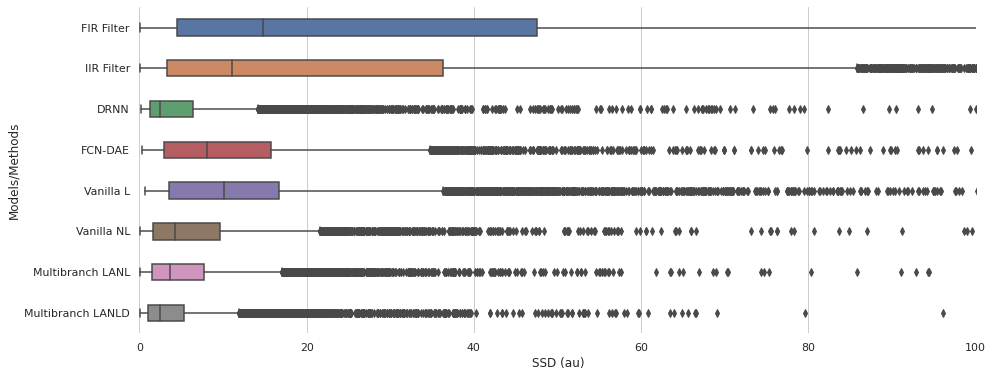

MAD Metric comparative graph


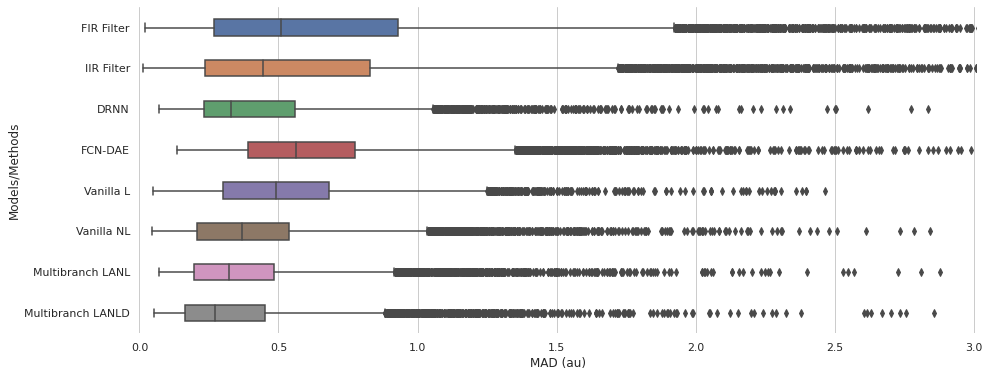

PRD Metric comparative graph


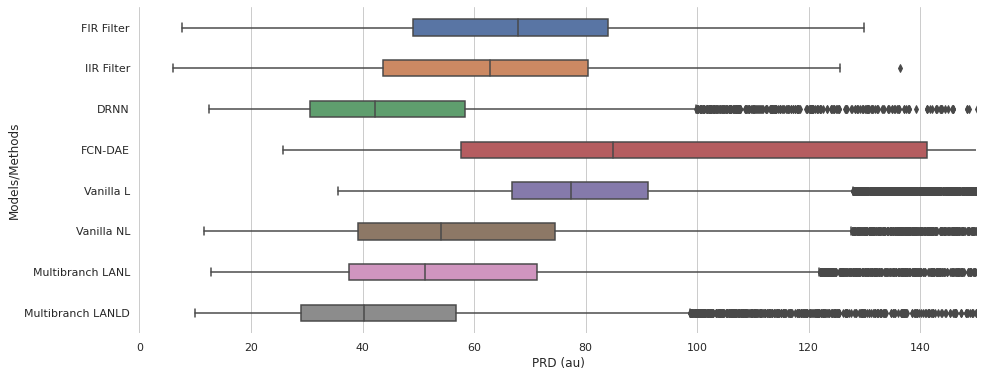

Cosine Similarity Metric comparative graph


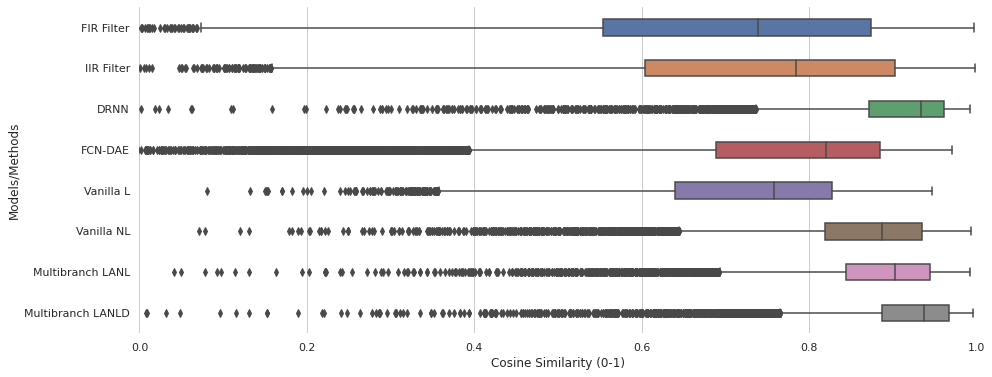

In [16]:
# Metrics graphs
print('SSD Metric comparative graph')
generate_hboxplot(SSD_all, Exp_names, 'SSD (au)', log=False, set_x_axis_size=(0, 100.1))
print('MAD Metric comparative graph')
generate_hboxplot(MAD_all, Exp_names, 'MAD (au)', log=False, set_x_axis_size=(0, 3.01))
print('PRD Metric comparative graph')
generate_hboxplot(PRD_all, Exp_names, 'PRD (au)', log=False, set_x_axis_size=(0, 150.1))
print('Cosine Similarity Metric comparative graph')
generate_hboxplot(CORR_all, Exp_names, 'Cosine Similarity (0-1)', log=False, set_x_axis_size=(0, 1))

In [17]:
# Visualize signals

signals_index = np.array([110, 210, 410, 810, 1610, 3210, 6410, 12810]) + 10

ecg_signals2plot = []
ecgbl_signals2plot = []
dl_signals2plot = []
fil_signals2plot = []

signal_amount = 10

[X_test, y_test, y_pred] = test_Multibranch_LANLD
for id in signals_index:
    ecgbl_signals2plot.append(X_test[id])
    ecg_signals2plot.append(y_test[id])
    dl_signals2plot.append(y_pred[id])

[X_test, y_test, y_filter] = test_IIR
for id in signals_index:
    fil_signals2plot.append(y_filter[id])

for i in range(len(signals_index)):
    ecg_view(ecg=ecg_signals2plot[i],
             ecg_blw=ecgbl_signals2plot[i],
             ecg_dl=dl_signals2plot[i],
             ecg_f=fil_signals2plot[i],
             signal_name=None,
             beat_no=None)

    ecg_view_diff(ecg=ecg_signals2plot[i],
                  ecg_blw=ecgbl_signals2plot[i],
                  ecg_dl=dl_signals2plot[i],
                  ecg_f=fil_signals2plot[i],
                  signal_name=None,
                  beat_no=None)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
while True:pass